## Example 2 - Plot PSDs for a station
This example requires that we have the PSD values already calculated for the target for the requested
days, and those values should live in the database.  If you have not already, you can run this command
to have the values generated for the target-days in this example:

    ./run_ispaq.py -M psd_corrected -S ANMO --starttime 2020-10-01 --endtime 2020-10-26 --output db

This example will assume that the above command has already been run and the PSDs already exist.

To begin, we need to import the necessary modules:

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime

Now we need to set some variables.

In [2]:
filename = 'PSD.png'
db_name = '../ispaq.db'
metric = 'psd_corrected'
startDate = '2020-10-01'
endDate = '2020-10-25'
target = 'IU.ANMO.00.BH1'
filename = f'example2_{target}_{startDate}_{endDate}_PSD.png'
filename2 = f'example2_{target}_{startDate}_{endDate}_PSD_bw.png'

The first step is to create a query that will be used to retrieve the psds.

In [3]:
SQLcommand = "SELECT * FROM " + metric + \
                     " WHERE start >= '" + startDate + "' " \
                     "and start < '" + endDate + "' " \
                     "and (target like '" + target + "');"

print('\nThis is the query used to retrieve the PSDs from the database:')
print(SQLcommand)


This is the query used to retrieve the PSDs from the database:
SELECT * FROM psd_corrected WHERE start >= '2020-10-01' and start < '2020-10-25' and (target like 'IU.ANMO.00.BH1');


Create a connection to the database and run the query, loading it into a pandas dataframe

In [9]:
try:
    conn = sqlite3.connect(db_name)
    DF = pd.read_sql_query(SQLcommand, conn, parse_dates=['start','end'])
    conn.close
except:
    print(f"Unable to connect to or find the {metric} table in the database {db_name}")

At this point, we have created a query to retrieve the metrics from the SQLite database, used sqlite3 to connect to the database, retreieved the metrics, closed the connection, and then ensured that the start times are in a datetime format for plotting purposes.

This is what the dataframe looks like:

In [10]:
print(DF)

                target  frequency     power               start  \
0       IU.ANMO.00.BH1   0.005256 -175.0380 2020-10-01 00:00:00   
1       IU.ANMO.00.BH1   0.005731 -174.3770 2020-10-01 00:00:00   
2       IU.ANMO.00.BH1   0.006250 -172.8040 2020-10-01 00:00:00   
3       IU.ANMO.00.BH1   0.006816 -172.0980 2020-10-01 00:00:00   
4       IU.ANMO.00.BH1   0.007433 -170.3700 2020-10-01 00:00:00   
...                ...        ...       ...                 ...   
108283  IU.ANMO.00.BH1  13.958500 -151.6420 2020-10-24 23:00:00   
108284  IU.ANMO.00.BH1  15.221900 -151.7540 2020-10-24 23:00:00   
108285  IU.ANMO.00.BH1  16.599500 -147.2440 2020-10-24 23:00:00   
108286  IU.ANMO.00.BH1  18.101900 -131.1240 2020-10-24 23:00:00   
108287  IU.ANMO.00.BH1  19.740300  -80.9941 2020-10-24 23:00:00   

                       end               lddate  
0      2020-10-01 01:00:00  2021-06-21 21:21:49  
1      2020-10-01 01:00:00  2021-06-21 21:21:49  
2      2020-10-01 01:00:00  2021-06-21 21:21:

The PSD plot will be power vs frequency, so we are going to group them together by start time:

In [11]:
DF = DF[['frequency','power','start']]
DFgrouped = DF.groupby(['start'])
print(DFgrouped)

We will take the information from the dataframe that we loaded and rearrange it for plotting.

In [12]:
plotDF = pd.DataFrame()
for name, group in DFgrouped:
    tmpDF = pd.DataFrame()
    tmpDF[name] = group['power']
    tmpDF.set_axis(group['frequency'], axis='index', inplace=True)

    plotDF = pd.concat([plotDF, tmpDF], axis=1, sort=False)

print("\nThis is the dataframe that will be used to plot:")
print(plotDF)


This is the dataframe that will be used to plot:
           2020-10-01 00:00:00  2020-10-01 00:30:00  2020-10-01 01:00:00  \
frequency                                                                  
0.005256             -175.0380            -176.8710            -151.7250   
0.005731             -174.3770            -176.2100            -151.0630   
0.006250             -172.8040            -174.7390            -149.1070   
0.006816             -172.0980            -174.0330            -148.4010   
0.007433             -170.3700            -172.7040            -145.8790   
...                        ...                  ...                  ...   
13.958500            -152.0840            -152.9600            -152.8730   
15.221900            -152.0070            -153.0570            -153.1540   
16.599500            -147.2870            -148.3630            -148.5770   
18.101900            -131.4190            -132.2900            -132.6120   
19.740300             -81.3095        

Now that we have the dataframe in this arrangement, we can start plotting it up.

First, a colorful version of the plot:

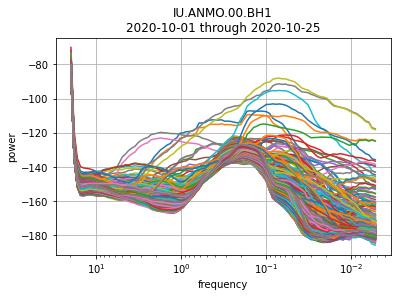

In [13]:
ax = plotDF.plot(legend=False, alpha=1, title=f'{target}\n{startDate} through {endDate}')
ax.set_xscale('log')
ax.invert_xaxis()
ax.set_ylabel('power')
plt.grid(True)
plt.savefig(filename)

Then, just for the sake of variety, a black and white version of the version of the plot:

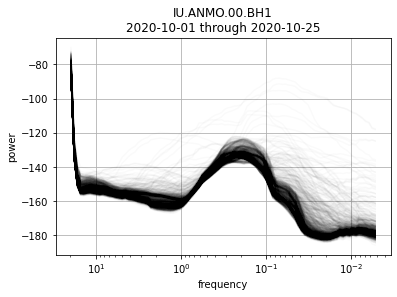

In [14]:
ax2 = plotDF.plot(legend=False, alpha=.02, color='k', title=f'{target}\n{startDate} through {endDate}')
ax2.set_xscale('log')
ax2.invert_xaxis()
ax2.set_ylabel('power')
plt.grid(True)
plt.savefig(filename2)